# Individual Skill Ratings

In [30]:
import re
import json
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

df = pd.read_json(path_or_buf="output/user_skill_graph-TEST.json", orient="records")
with open("pair-app-data/skill-words.json") as input_file:
    words = json.load(input_file)

df['categories'] = df['categories'].apply(tuple)
new_rows = []
for index, row in df.iterrows():
    new_rows.extend([[row['helperId'], row['timestamp'], row['task'][0], nn, row['value']] for nn in row.categories])
expanded_df = pd.DataFrame(new_rows,columns=['helperId', 'timestamp', 'task', 'category', 'value'])

skill_df = pd.read_csv('pair-app-data/skill-poll.csv')

In [31]:
def grab_user_responses(userId, pair_responses):
    user_responses = pair_responses[pair_responses['helperId'] == userId]
    return user_responses

def calculate_skill_scores(user_response_df):
    return user_response_df.groupby('category').mean()

def get_skill_scores(userId, pair_responses):
    res = grab_user_responses(userId, pair_responses);
    skill_df = calculate_skill_scores(res);
    return skill_df

---
Diff is equal to the (pair research skill - reported skill)


In [32]:
def find_diffs_and_values(userId, pair_responses, skill_responses):
    poll_skill_df = skill_df[skill_df["userId"] == userId]
    pair_skill_df = get_skill_scores(userId, pair_responses);

    transposed_poll_skill_df = poll_skill_df.T
    transposed_poll_skill_df.columns = ["value"]
    transposed_poll_skill_df.index = transposed_poll_skill_df.index.str.lower()
    
    result = {}
    for index, row in pair_skill_df.iterrows():
        if index in transposed_poll_skill_df.index:
            diff = (pair_skill_df.loc[index].value - transposed_poll_skill_df.loc[index]["value"])
            result[index] = {}
            result[index]["pairRating"] = pair_skill_df.loc[index].value
            result[index]["pollRating"] = transposed_poll_skill_df.loc[index]["value"]
            result[index]["diff"] = diff
    
    return result



def find_diffs(userId, pair_responses, skill_responses):
    poll_skill_df = skill_df[skill_df["userId"] == userId]
    pair_skill_df = get_skill_scores(userId, pair_responses);

    transposed_poll_skill_df = poll_skill_df.T
    transposed_poll_skill_df.columns = ["value"]
    transposed_poll_skill_df.index = transposed_poll_skill_df.index.str.lower()
    
    result = {}
    result["userId"] = userId
    for index, row in pair_skill_df.iterrows():
        if index in transposed_poll_skill_df.index:
            diff = (pair_skill_df.loc[index].value - transposed_poll_skill_df.loc[index]["value"])
            result[index] = diff
    
    return result


In [33]:
find_diffs("u6DrqFSvdZnWDgjz8", expanded_df, skill_df)

{u'algorithms': 0.0,
 u'brainstorming': -1.0,
 u'data analysis': -1.0,
 u'debugging': 1.0,
 u'dev tools': -1.3333333333333333,
 u'feedback': 1.0,
 u'general tech': -0.5,
 u'grants': 0.0,
 u'interaction design': 0.0,
 u'prototype testing': 0.5,
 u'research direction': -1.2000000000000002,
 u'study design': 0.5,
 u'ui/ux design': -0.5,
 'userId': 'u6DrqFSvdZnWDgjz8',
 u'web/mobile dev': -2.2999999999999998}

In [34]:
userIds = list(skill_df['userId'])
heatMapList = []
for userId in userIds:
    res = find_diffs(userId, expanded_df, skill_df)
    heatMapList.append(res);
heatMapList

[{u'algorithms': -3.0,
  u'brainstorming': -2.1000000000000001,
  u'data analysis': -1.0,
  u'debugging': 0.0,
  u'dev tools': 0.83333333333333348,
  u'feedback': -1.6000000000000001,
  u'general tech': -2.0,
  u'grants': 0.92857142857142838,
  u'interaction design': -1.6666666666666665,
  u'pair programming': -1.0,
  u'prototype testing': -1.6666666666666665,
  u'related work': 2.0,
  u'research direction': 0.75,
  u'study design': 0.75,
  u'ui/ux design': -1.8999999999999999,
  'userId': 'dZ23LYG2G42mY3NAf',
  u'web/mobile dev': -1.5714285714285716},
 {u'algorithms': 0.0,
  u'brainstorming': -0.92857142857142838,
  u'data analysis': -0.5,
  u'debugging': -2.0,
  u'dev tools': -2.3999999999999999,
  u'feedback': -1.1666666666666665,
  u'general tech': -2.0,
  u'grants': 1.8888888888888888,
  u'interaction design': -1.6666666666666665,
  u'pair programming': -3.0,
  u'prototype testing': -1.0,
  u'research direction': -0.29999999999999982,
  u'study design': -1.25,
  u'ui/ux design': -

In [35]:
heatMapDf = pd.DataFrame(heatMapList)
heatMapDf = heatMapDf.set_index(['userId'])
heatMapDf = heatMapDf[np.isfinite(heatMapDf['grants'])]
heatMapDf.values.max()

nan

In [36]:
def heatmap(df,
            edgecolors='w',
            cmap=mpl.cm.RdBu,
            log=False,vmin=0,vmax=500):    
    width = len(df.columns)/4
    height = len(df.index)/4
    
    fig, ax = plt.subplots(figsize=(width,height))
      
    heatmap = ax.pcolor(df,
                        edgecolors=edgecolors,  # put white lines between squares in heatmap
                        cmap=cmap,
                        vmin=vmin, # defaults to 0
                        vmax=vmax, # defaults to 500
                        norm=mpl.colors.LogNorm() if log else None)
    
    ax.autoscale(tight=True)  # get rid of whitespace in margins of heatmap
    ax.set_aspect('equal')  # ensure heatmap cells are square
    ax.xaxis.set_ticks_position('top')  # put column labels at the top
    ax.tick_params(bottom='off', top='off', left='off', right='off')  # turn off ticks
    
    plt.yticks(np.arange(len(df.index)) + 0.5, df.index)
    plt.xticks(np.arange(len(df.columns)) + 0.5, df.columns, rotation=90)
    
    # ugliness from http://matplotlib.org/users/tight_layout_guide.html
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", "3%", pad="1%")
    plt.colorbar(heatmap, cax=cax)
    return fig

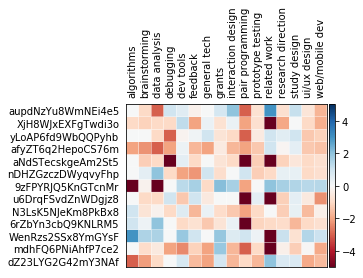

In [37]:
heatmap(heatMapDf, vmin=-5, vmax=5)

Diff is equal to the (pair research skill - reported skill). Most people seem to rate themselves higher than they do within the Pair Research Tool

In [38]:
heatMapDf.describe()

,algorithms,brainstorming,data analysis,debugging,dev tools,feedback,general tech,grants,interaction design,pair programming,prototype testing,related work,research direction,study design,ui/ux design,web/mobile dev
count,12.000000,13.000000,12.000000,12.000000,13.000000,13.000000,13.000000,13.000000,13.000000,10.000000,13.000000,8.000000,13.000000,13.000000,13.000000,13.000000
mean,-0.083333,-0.634049,-0.508333,-0.666667,0.032021,-0.648718,-0.474359,0.208164,-0.256410,-1.600000,-0.760203,0.875000,-0.240757,0.154396,-0.652767,-0.932525
std,1.505042,1.047318,1.671939,1.230915,1.330323,1.267826,1.092581,1.177863,1.248361,1.505545,0.657846,1.457738,1.079010,0.957159,1.040154,1.114740
min,-3.000000,-2.250000,-3.000000,-3.000000,-2.400000,-2.200000,-2.000000,-0.916667,-1.666667,-3.000000,-1.666667,-1.000000,-1.923077,-1.666667,-1.900000,-2.300000
25%,-0.250000,-1.142857,-1.000000,-1.250000,-1.000000,-1.666667,-1.333333,-0.692308,-1.333333,-2.750000,-1.214286,-0.250000,-1.153846,-0.600000,-1.333333,-1.714286
50%,0.000000,-0.928571,-1.000000,-0.500000,0.500000,-1.000000,0.000000,-0.461538,0.000000,-2.000000,-1.000000,1.000000,-0.300000,0.428571,-1.000000,-1.142857
75%,0.250000,0.000000,0.250000,0.000000,0.833333,0.200000,0.333333,0.928571,0.333333,-1.250000,-0.461538,2.000000,0.583333,0.750000,-0.500000,-0.814815
max,3.000000,1.545455,2.000000,1.000000,1.888889,1.666667,1.000000,2.125000,2.000000,1.000000,0.500000,3.000000,1.666667,1.500000,1.476190,1.416667


                    poll     pair
algorithms             2        1
brainstorming          4      2.9
data analysis          5        1
debugging              4        2
dev tools              2  2.83333
feedback               4      3.4
general tech           3        1
grants                 2  2.92857
interaction design     3  3.33333
needfinding            3      NaN
pair programming       4        2
paper writing          4      NaN
prototype design     NaN      2.4
prototype testing      4  3.33333
recruiting             2      NaN
related work           1        4
research direction     4     2.75
study design           1     3.75
system architecture    2      NaN
ui/ux design           4      3.1
user studies           1      NaN
web/mobile dev         4  2.42857


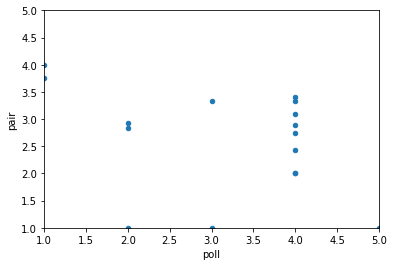

                    poll     pair
algorithms             2        5
architecture         NaN        2
brainstorming          4  3.07143
data analysis          5      4.5
debugging              4        3
dev tools              2      2.6
feedback               4  2.83333
general tech           3        3
grants                 2  2.88889
interaction design     3  2.33333
needfinding            3      NaN
pair programming       4        2
paper writing          4      NaN
prototype design     NaN  2.83333
prototype testing      4        3
recruiting             2      NaN
related work           1      NaN
research direction     4      2.7
study design           1     2.75
system architecture    2      NaN
ui/ux design           4  2.94737
user studies           1      NaN
web/mobile dev         4  3.11111


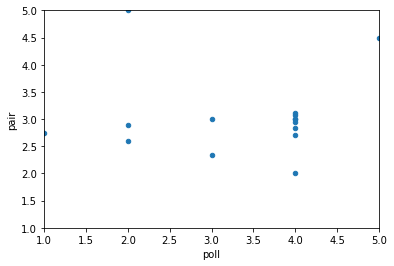

                    poll     pair
algorithms             2        4
architecture         NaN        3
brainstorming          4  3.54545
data analysis          5      3.6
debugging              4        3
dev tools              2  2.88889
feedback               4        4
general tech           3        3
grants                 2  2.92308
interaction design     3  2.66667
needfinding            3      NaN
pair programming       4        4
paper writing          4      NaN
prototype design     NaN  2.83333
prototype testing      4  3.26667
recruiting             2      NaN
related work           1      NaN
research direction     4  3.10526
study design           1     2.25
system architecture    2      NaN
ui/ux design           4  3.47619
user studies           1      NaN
web/mobile dev         4  3.08824


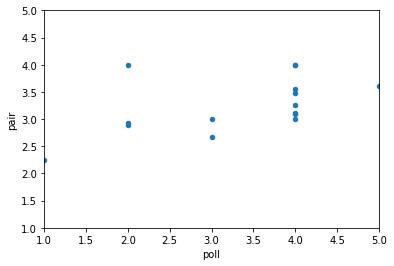

                    poll pair
algorithms             2  NaN
brainstorming          4  NaN
data analysis          5  NaN
debugging              4  NaN
dev tools              2  NaN
feedback               4  NaN
general tech           3  NaN
grants                 2  NaN
interaction design     3  NaN
needfinding            3  NaN
pair programming       4  NaN
paper writing          4  NaN
prototype testing      4  NaN
recruiting             2  NaN
related work           1  NaN
research direction     4  NaN
study design           1  NaN
system architecture    2  NaN
ui/ux design           4  NaN
user studies           1  NaN
web/mobile dev         4  NaN


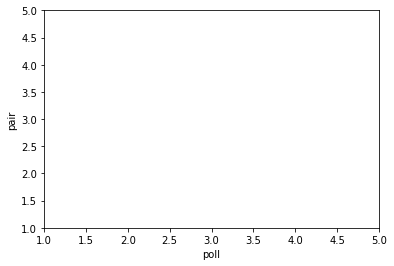

                    poll     pair
algorithms             2        4
brainstorming          4     3.25
data analysis          5        4
debugging              4        4
dev tools              2        2
feedback               4     2.25
general tech           3  2.66667
grants                 2  1.33333
interaction design     3  3.33333
needfinding            3      NaN
pair programming       4      NaN
paper writing          4      NaN
prototype design     NaN      2.2
prototype testing      4    2.875
recruiting             2      NaN
related work           1        2
research direction     4  2.07143
study design           1  1.33333
system architecture    2      NaN
ui/ux design           4        3
user studies           1      NaN
web/mobile dev         4  3.18519


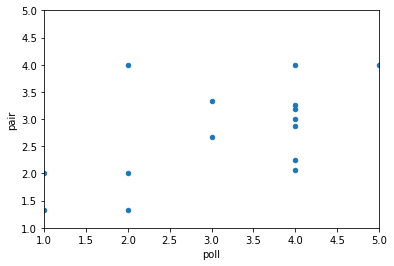

                    poll     pair
algorithms             2        3
architecture         NaN        3
brainstorming          4  3.33333
data analysis          5      1.8
debugging              4        1
dev tools              2    2.625
feedback               4  3.33333
general tech           3  3.33333
grants                 2  3.08333
interaction design     3  3.66667
needfinding            3      NaN
pair programming       4        1
paper writing          4      NaN
prototype design     NaN  4.28571
prototype testing      4        4
recruiting             2      NaN
related work           1        3
research direction     4     2.76
study design           1  3.42857
system architecture    2      NaN
ui/ux design           4  3.41667
user studies           1      NaN
web/mobile dev         4   2.7027


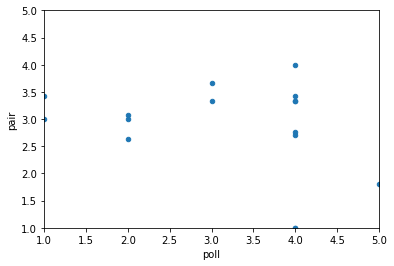

                    poll     pair
algorithms             2        2
brainstorming          4        4
data analysis          5        2
debugging              4        5
dev tools              2  1.66667
feedback               4        4
general tech           3      3.5
grants                 2        1
interaction design     3        4
needfinding            3      NaN
pair programming       4      NaN
paper writing          4      NaN
prototype design     NaN  3.33333
prototype testing      4      3.5
recruiting             2      NaN
related work           1      NaN
research direction     4      2.8
study design           1      2.5
system architecture    2      NaN
ui/ux design           4      2.5
user studies           1      NaN
web/mobile dev         4      1.7


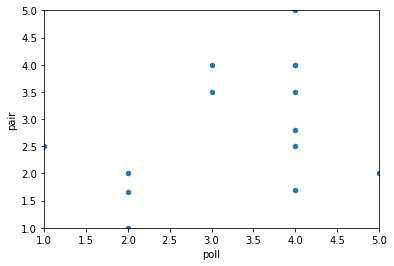

                    poll     pair
algorithms             2      NaN
brainstorming          4      2.8
data analysis          5      NaN
debugging              4        2
dev tools              2  2.33333
feedback               4  4.66667
general tech           3        1
grants                 2    4.125
interaction design     3  3.66667
needfinding            3      NaN
pair programming       4        1
paper writing          4      NaN
prototype design     NaN     2.25
prototype testing      4        2
recruiting             2      NaN
related work           1        4
research direction     4  3.66667
study design           1      3.5
system architecture    2      NaN
ui/ux design           4      3.4
user studies           1      NaN
web/mobile dev         4  2.41667


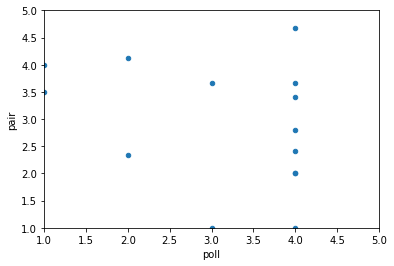

                    poll pair
algorithms             2  NaN
brainstorming          4  NaN
data analysis          5  NaN
debugging              4  NaN
dev tools              2  NaN
feedback               4  NaN
general tech           3  NaN
grants                 2  NaN
interaction design     3  NaN
needfinding            3  NaN
pair programming       4  NaN
paper writing          4  NaN
prototype testing      4  NaN
recruiting             2  NaN
related work           1  NaN
research direction     4  NaN
study design           1  NaN
system architecture    2  NaN
ui/ux design           4  NaN
user studies           1  NaN
web/mobile dev         4  NaN


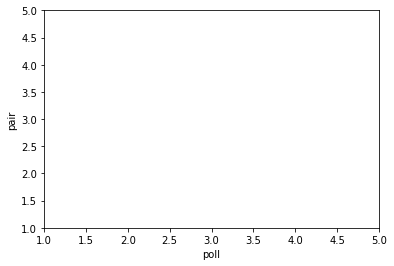

                    poll     pair
algorithms             2        4
brainstorming          4      3.5
data analysis          5        4
debugging              4        2
dev tools              2        3
feedback               4      2.8
general tech           3        5
grants                 2  3.13333
interaction design     3        2
needfinding            3      NaN
pair programming       4        5
paper writing          4      NaN
prototype design     NaN  3.28571
prototype testing      4  2.78571
recruiting             2      NaN
related work           1        3
research direction     4  3.42857
study design           1  3.42857
system architecture    2      NaN
ui/ux design           4        3
user studies           1      NaN
web/mobile dev         4  3.16667


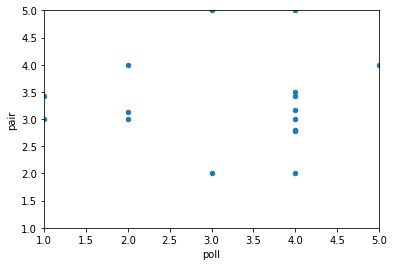

                    poll pair
algorithms             2  NaN
brainstorming          4  NaN
data analysis          5  NaN
debugging              4  NaN
dev tools              2  NaN
feedback               4  NaN
general tech           3  NaN
grants                 2  NaN
interaction design     3  NaN
needfinding            3  NaN
pair programming       4  NaN
paper writing          4  NaN
prototype testing      4  NaN
recruiting             2  NaN
related work           1  NaN
research direction     4  NaN
study design           1  NaN
system architecture    2  NaN
ui/ux design           4  NaN
user studies           1  NaN
web/mobile dev         4  NaN


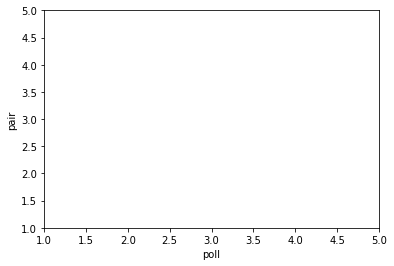

                    poll     pair
algorithms             2        2
architecture         NaN        4
brainstorming          4     2.75
data analysis          5        2
debugging              4      NaN
dev tools              2      2.5
feedback               4        3
general tech           3        3
grants                 2  3.33333
interaction design     3        3
needfinding            3      NaN
pair programming       4      NaN
paper writing          4      NaN
prototype design     NaN        3
prototype testing      4     2.75
recruiting             2      NaN
related work           1      NaN
research direction     4  2.84615
study design           1      3.4
system architecture    2      NaN
ui/ux design           4        3
user studies           1      NaN
web/mobile dev         4  3.18519


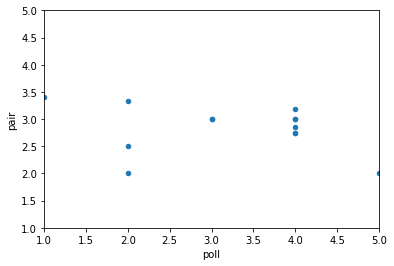

                    poll     pair
algorithms             2        1
architecture         NaN        4
brainstorming          4     2.75
data analysis          5        1
debugging              4        1
dev tools              2  2.28571
feedback               4  3.33333
general tech           3        1
grants                 2  2.53846
interaction design     3  3.33333
needfinding            3      NaN
pair programming       4        2
paper writing          4      NaN
prototype design     NaN        4
prototype testing      4  3.63636
recruiting             2      NaN
related work           1        4
research direction     4      2.9
study design           1      3.5
system architecture    2      NaN
ui/ux design           4  3.66667
user studies           1      NaN
web/mobile dev         4     2.55


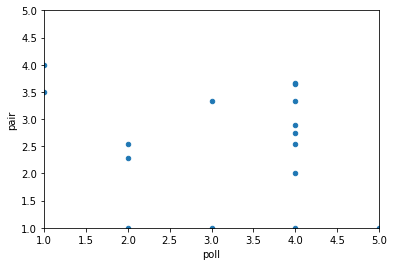

                    poll     pair
algorithms             2        3
brainstorming          4        4
data analysis          5        3
debugging              4        1
dev tools              2  2.83333
feedback               4      4.2
general tech           3        5
grants                 2  3.30769
interaction design     3        4
needfinding            3      NaN
pair programming       4        2
paper writing          4      NaN
prototype design     NaN  3.66667
prototype testing      4  3.53846
recruiting             2      NaN
related work           1        4
research direction     4  3.58333
study design           1        4
system architecture    2      NaN
ui/ux design           4     3.65
user studies           1      NaN
web/mobile dev         4  2.85714


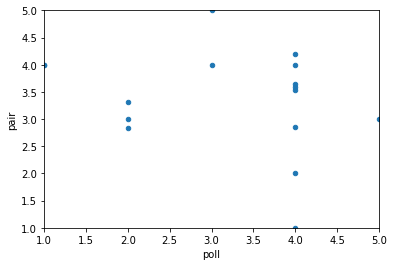

                    poll     pair
algorithms             2        1
brainstorming          4  2.85714
data analysis          5        1
debugging              4        1
dev tools              2     2.25
feedback               4        3
general tech           3  3.33333
grants                 2  2.22222
interaction design     3  4.33333
needfinding            3      NaN
pair programming       4        1
paper writing          4      NaN
prototype design     NaN  3.66667
prototype testing      4  3.18182
recruiting             2      NaN
related work           1      NaN
research direction     4  3.07692
study design           1        3
system architecture    2      NaN
ui/ux design           4        3
user studies           1      NaN
web/mobile dev         4      2.2


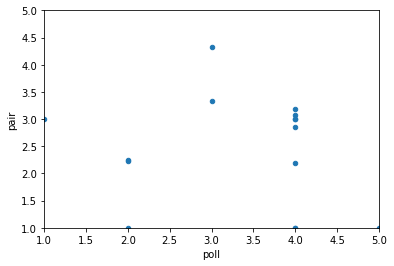

                    poll     pair
algorithms             2        2
brainstorming          4        3
data analysis          5        2
debugging              4        5
dev tools              2      2.6
feedback               4     3.75
general tech           3        3
grants                 2  2.88889
interaction design     3        5
needfinding            3      NaN
pair programming       4        1
paper writing          4      NaN
prototype design     NaN      3.5
prototype testing      4     3.25
recruiting             2      NaN
related work           1        4
research direction     4  3.18182
study design           1  2.16667
system architecture    2      NaN
ui/ux design           4  3.35714
user studies           1      NaN
web/mobile dev         4  2.28571


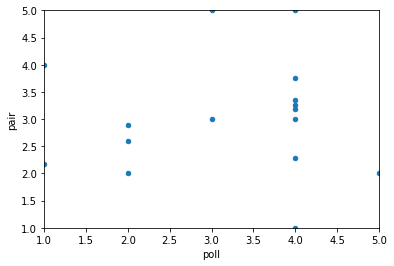

In [94]:
userIds = list(skill_df['userid'])
lower_skill_df = skill_df
lower_skill_df.columns = map(str.lower, lower_skill_df.columns)

for user in userIds:
    curr_row = lower_skill_df[lower_skill_df["userid"] == userId]
    user_scores = get_skill_scores(user, expanded_df).T
    frames = [curr_row, user_scores]
    res = pd.concat(frames)
    res = res.T
    res.columns = ["poll", "pair"]
    res = res.drop(["timestamp", "userid", "how many quarters have you been in dtr?", "what is your current status in university?", "what's your name?"])
#     plt.scatter(res.poll, res.pair, xlim=(1, 5), ylim=(1, 5))
    res.plot(kind='scatter', x='poll', y='pair', xlim=(1, 5), ylim=(1, 5))
    print res
    plt.show()